# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [1]:
# Имрортируем необходимые библиотеки

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%pylab inline

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [8]:
df = pd.read_csv('train_data/orange_small_churn_data.txt')

with open('train_data/orange_small_churn_labels.txt', 'r') as fin:
    df['churn'] = list(map(lambda s: int(s.strip()), fin.readlines()))

# (Optional) Write to the file
# df.to_csv(path_or_buf='train_data/churn_train_data.csv',index=False)

In [2]:
# (Optional) Read from the file
df = pd.read_csv('train_data/churn_train_data.csv')

In [3]:
# Split columns

num_features = df.columns[:190]
cat_features = df.columns[190:-1]

In [4]:
# Clear data
df = df.dropna(axis=0, how='all', subset=df.columns[:-1])
df = df.dropna(axis=1, how='all')

num_features = num_features.intersection(df.columns)
cat_features = cat_features.intersection(df.columns)

2\. Рассчитайте доли классов `отток` и `не отток`.

In [5]:
df.churn.value_counts() / len(df)

-1    0.9256
 1    0.0744
Name: churn, dtype: float64

Можно видеть, что выборка очень несбалансированая: имеется более чем *92%* пользователей, принадлежащих классу `не отток` и лишь оставшиеся порядка *7%* - пользователи интересующего нас класса `отток`.

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles 

In [6]:
# Функции для расчета корреляций

def num_features_binary_target_corr():
    """
    An empirical rule E(X1|X2 = 1) - E(X1|X2 = 0) is used
    """
    for f_name in num_features:
        corr_v = df[f_name][df.churn == 1].mean() - df[f_name][df.churn == -1].mean()
        yield f_name, corr_v
        

def cat_features_binary_target_corr():
    """
    Cramer's V coefficient is used
    """
    for f_name in cat_features:
        confusion_mx = pd.crosstab(df[f_name], df.churn)
        n = confusion_mx.sum().sum()
        phi2 = ss.chi2_contingency(confusion_mx)[0] / n
        r, k = confusion_mx.shape
        phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
        rcorr = r-((r-1)**2)/(n-1)
        kcorr = k-((k-1)**2)/(n-1)
        yield f_name, np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [8]:
# Расчет величин корреляций с целевой переменной
num_corrs = pd.DataFrame.from_dict(dict(num_features_binary_target_corr()), orient='index', columns=['correlation'])
cat_corrs = pd.DataFrame.from_dict(dict(cat_features_binary_target_corr()), orient='index', columns=['correlation'])

In [12]:
# Топ-5 положительно коррелированных вещественных признаков
num_corrs.sort_values(by='correlation', ascending=False).head()

,correlation
Var131,1.034608e+07
Var69,4.808584e+05
Var53,4.389077e+05
Var177,4.017487e+05
Var180,3.201630e+05


In [13]:
print(f"Всего положительно коррелированных вещественных: {len(num_corrs[num_corrs.correlation > 0])} из {len(num_corrs)}")

Всего положительно коррелированных вещественных: 69 из 174


In [14]:
# Топ-5 положительно коррелированных категориальных признаков
cat_corrs.sort_values(by='correlation', ascending=False).head()

,correlation
Var199,0.237375
Var192,0.116264
Var216,0.083442
Var206,0.077436
Var212,0.075150


4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

In [81]:
# Function for more flexible visualization
import itertools


def trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


def plot_hist(data):
    n = 5
    m = int(np.floor(data.shape[1] / n))
    fig, axs = plt.subplots(m, n, figsize=(6*n, 6*m), constrained_layout=True)
    axs = trim_axs(axs, data.shape[1])
    
    for ax, col in zip(axs, data.columns):
        sns.distplot(data[col][df.churn == -1].dropna(), ax=ax)
        sns.distplot(data[col][df.churn == 1].dropna(), ax=ax)
        

def plot_pairs(data):
    # filter pairs without intersections to reduce a number of plots
    pairs = list(itertools.combinations(data.columns.values, 2))
    pairs = [p for p in pairs if not data[[p[0], p[1]]].dropna().empty]
    
    n = 8
    m = int(np.floor(len(pairs) / n))
    fig, axs = plt.subplots(m, n, figsize=(6*n, 6*m), constrained_layout=True)
    axs = trim_axs(axs, len(pairs))
    
    hue = df.churn.apply(lambda x: 'отток' if x == 1 else 'не отток')
    for ax, clms in zip(axs, pairs):
        sns.scatterplot(x=clms[0], y=clms[1], data=data, hue=hue, ax=ax)

Для начала взглянем на сами переменные:

In [82]:
top_20 = num_corrs.sort_values(by='correlation', ascending=False).index[:20]
df[top_20].describe().T

,count,mean,std,min,25%,50%,75%,max
Var131,570.0,4.159484e+06,2.584101e+07,0.0,0.0,0.000,0.00,442233600.0
Var69,1165.0,3.538868e+06,4.942787e+06,0.0,0.0,432972.000,6376329.00,18741870.0
Var53,570.0,6.486416e+05,1.334177e+06,0.0,0.0,89244.000,713601.00,12513150.0
Var177,1006.0,6.252132e+05,1.321047e+06,0.0,0.0,0.000,554412.25,8554350.0
Var180,570.0,3.823922e+06,3.762206e+06,0.0,272135.5,2423981.000,6593977.25,14284830.0
Var114,1006.0,6.116184e+05,9.332979e+05,0.0,0.0,7021.000,974294.50,4267360.0
Var111,890.0,2.960736e+05,5.264826e+05,0.0,0.0,94314.305,390408.00,3628806.0
Var113,40000.0,-1.542483e+05,7.615541e+05,-9803600.0,-184762.7,29327.940,147005.80,9932480.0
Var153,35984.0,6.186849e+06,4.347667e+06,0.0,1237981.0,8138440.000,10376120.00,13907800.0
Var10,1165.0,3.813466e+05,9.353348e+05,0.0,0.0,0.000,241974.00,12325590.0


Видно, что распределение некоторых переменных сильно скошено. Для наглядности нормируем значения, чтобы уменьшить масштаб:

In [83]:
norm_top_20 = df[top_20]
norm_top_20 = (norm_top_20 - norm_top_20.min()) / (norm_top_20.max() - norm_top_20.min())

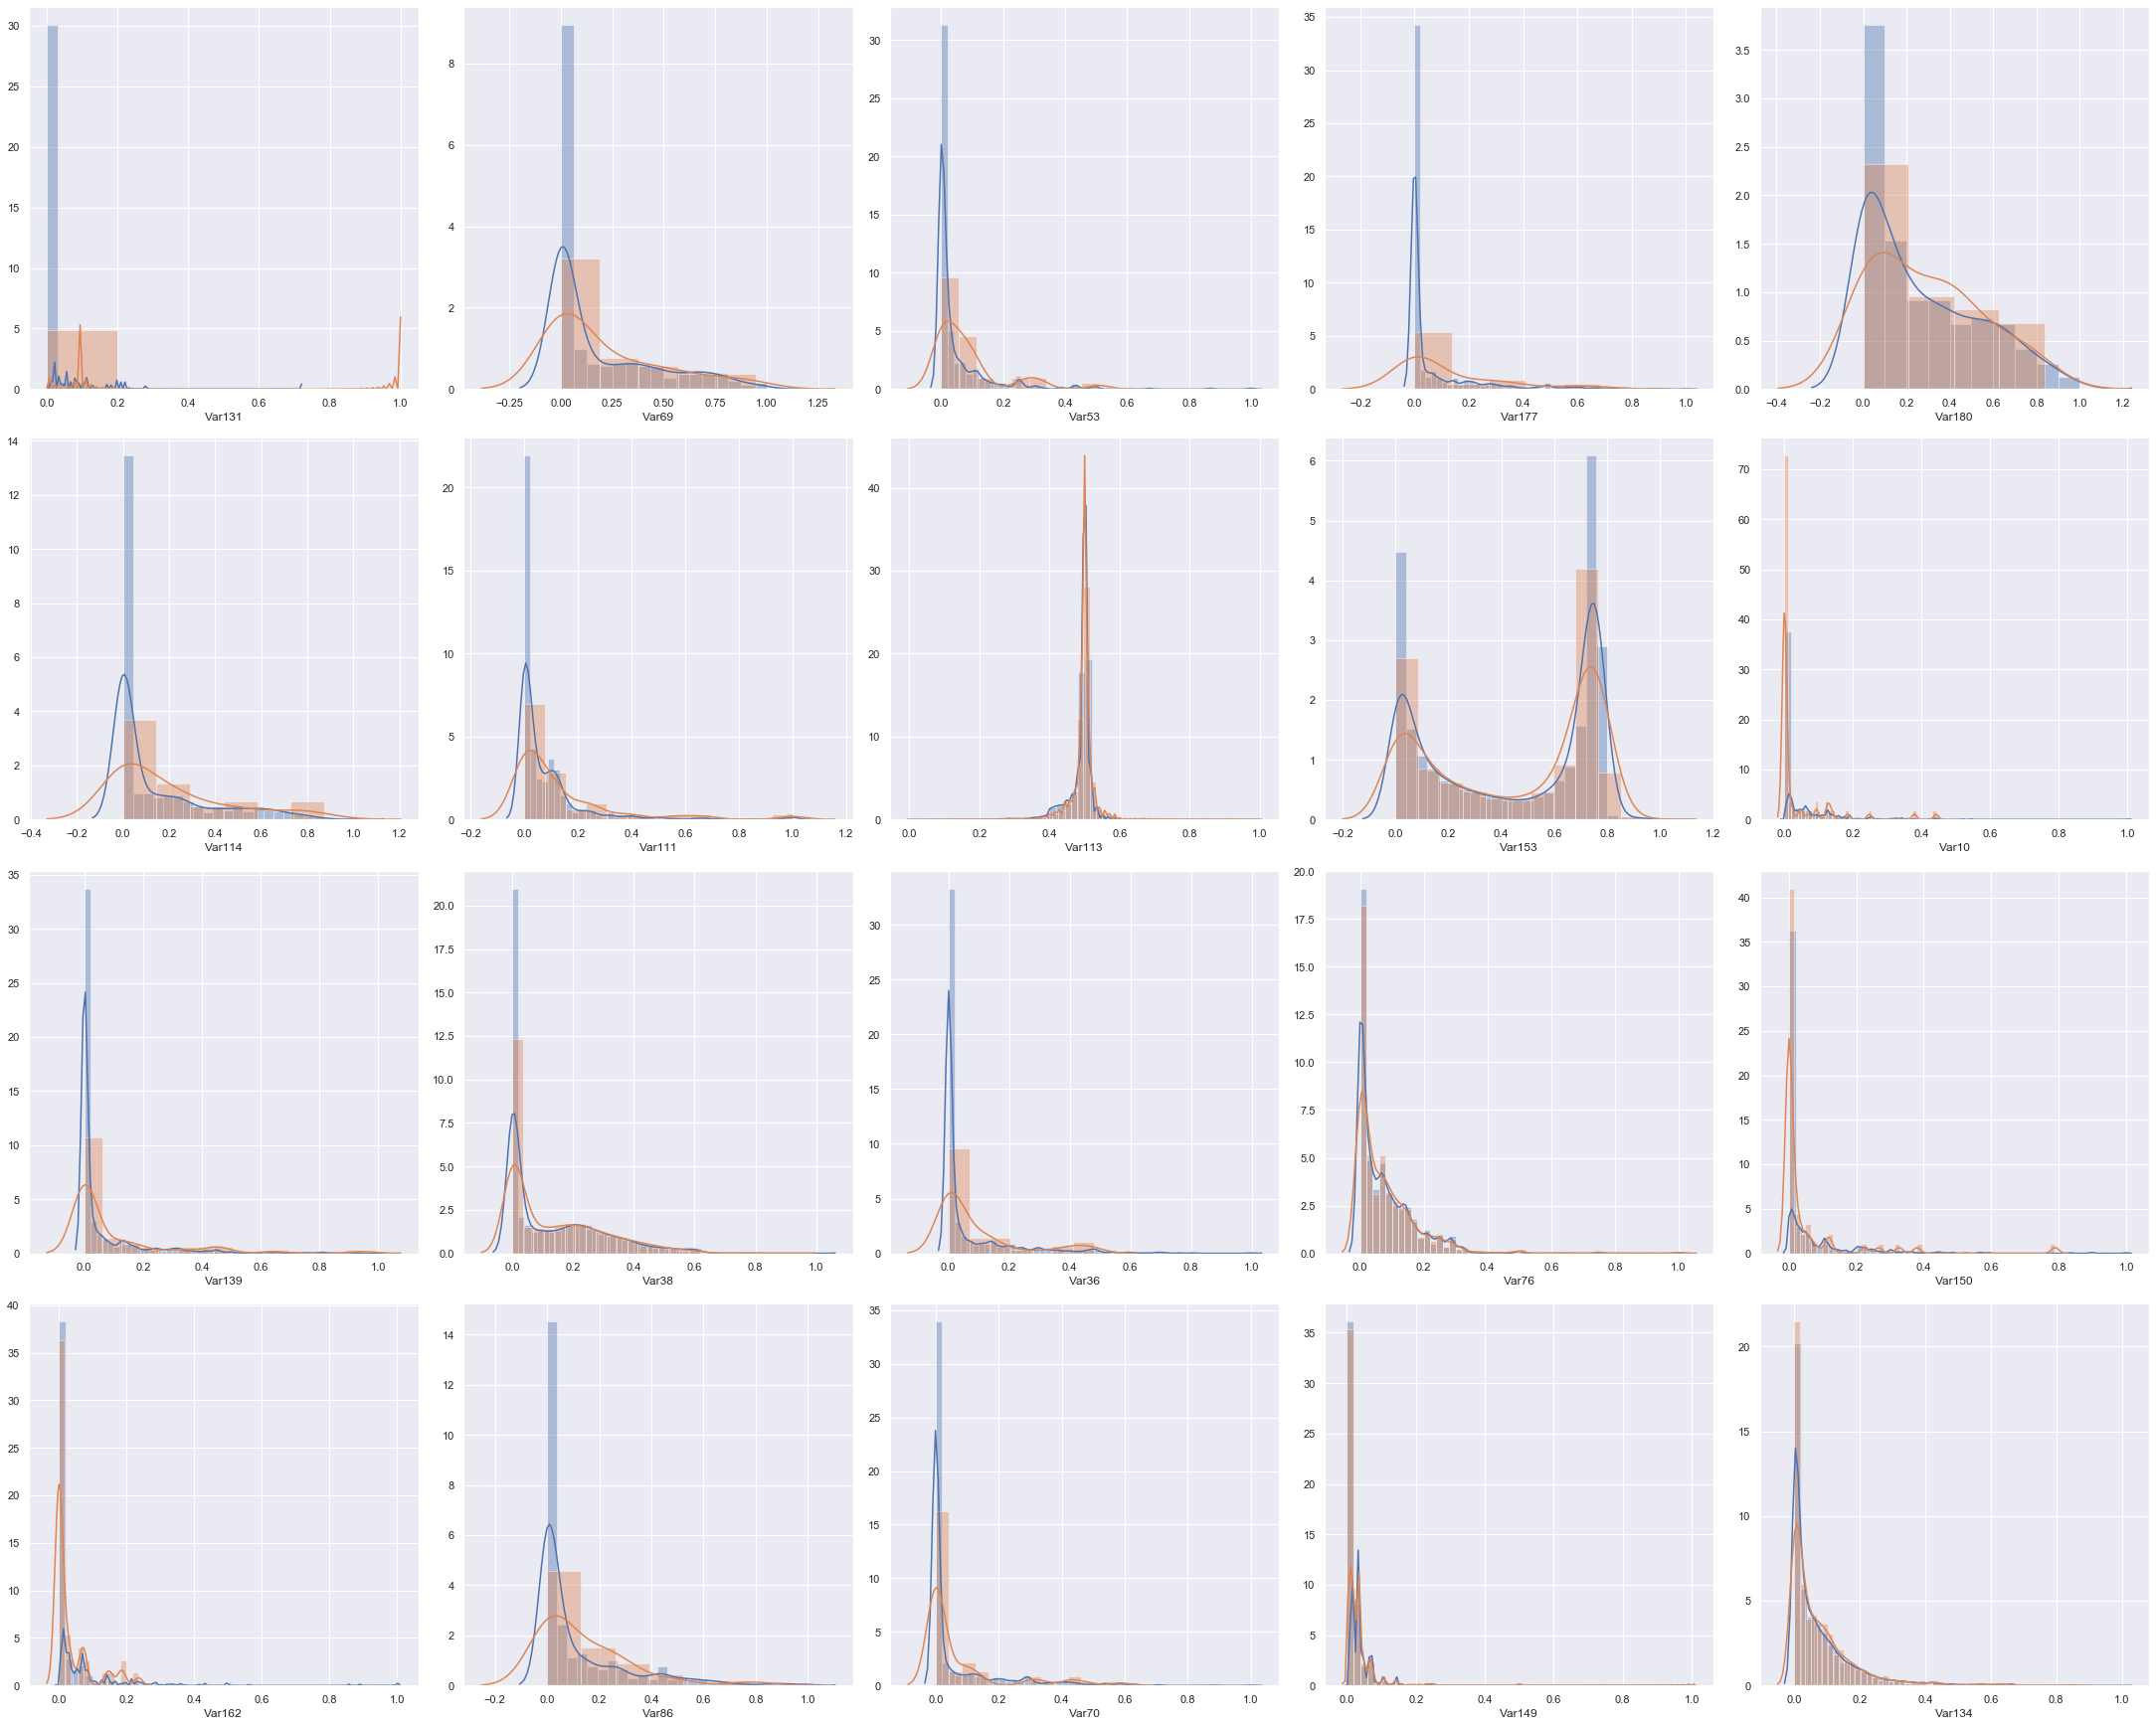

In [55]:
# Вывод гистограмм распределения признаков
plot_hist(norm_top_20)

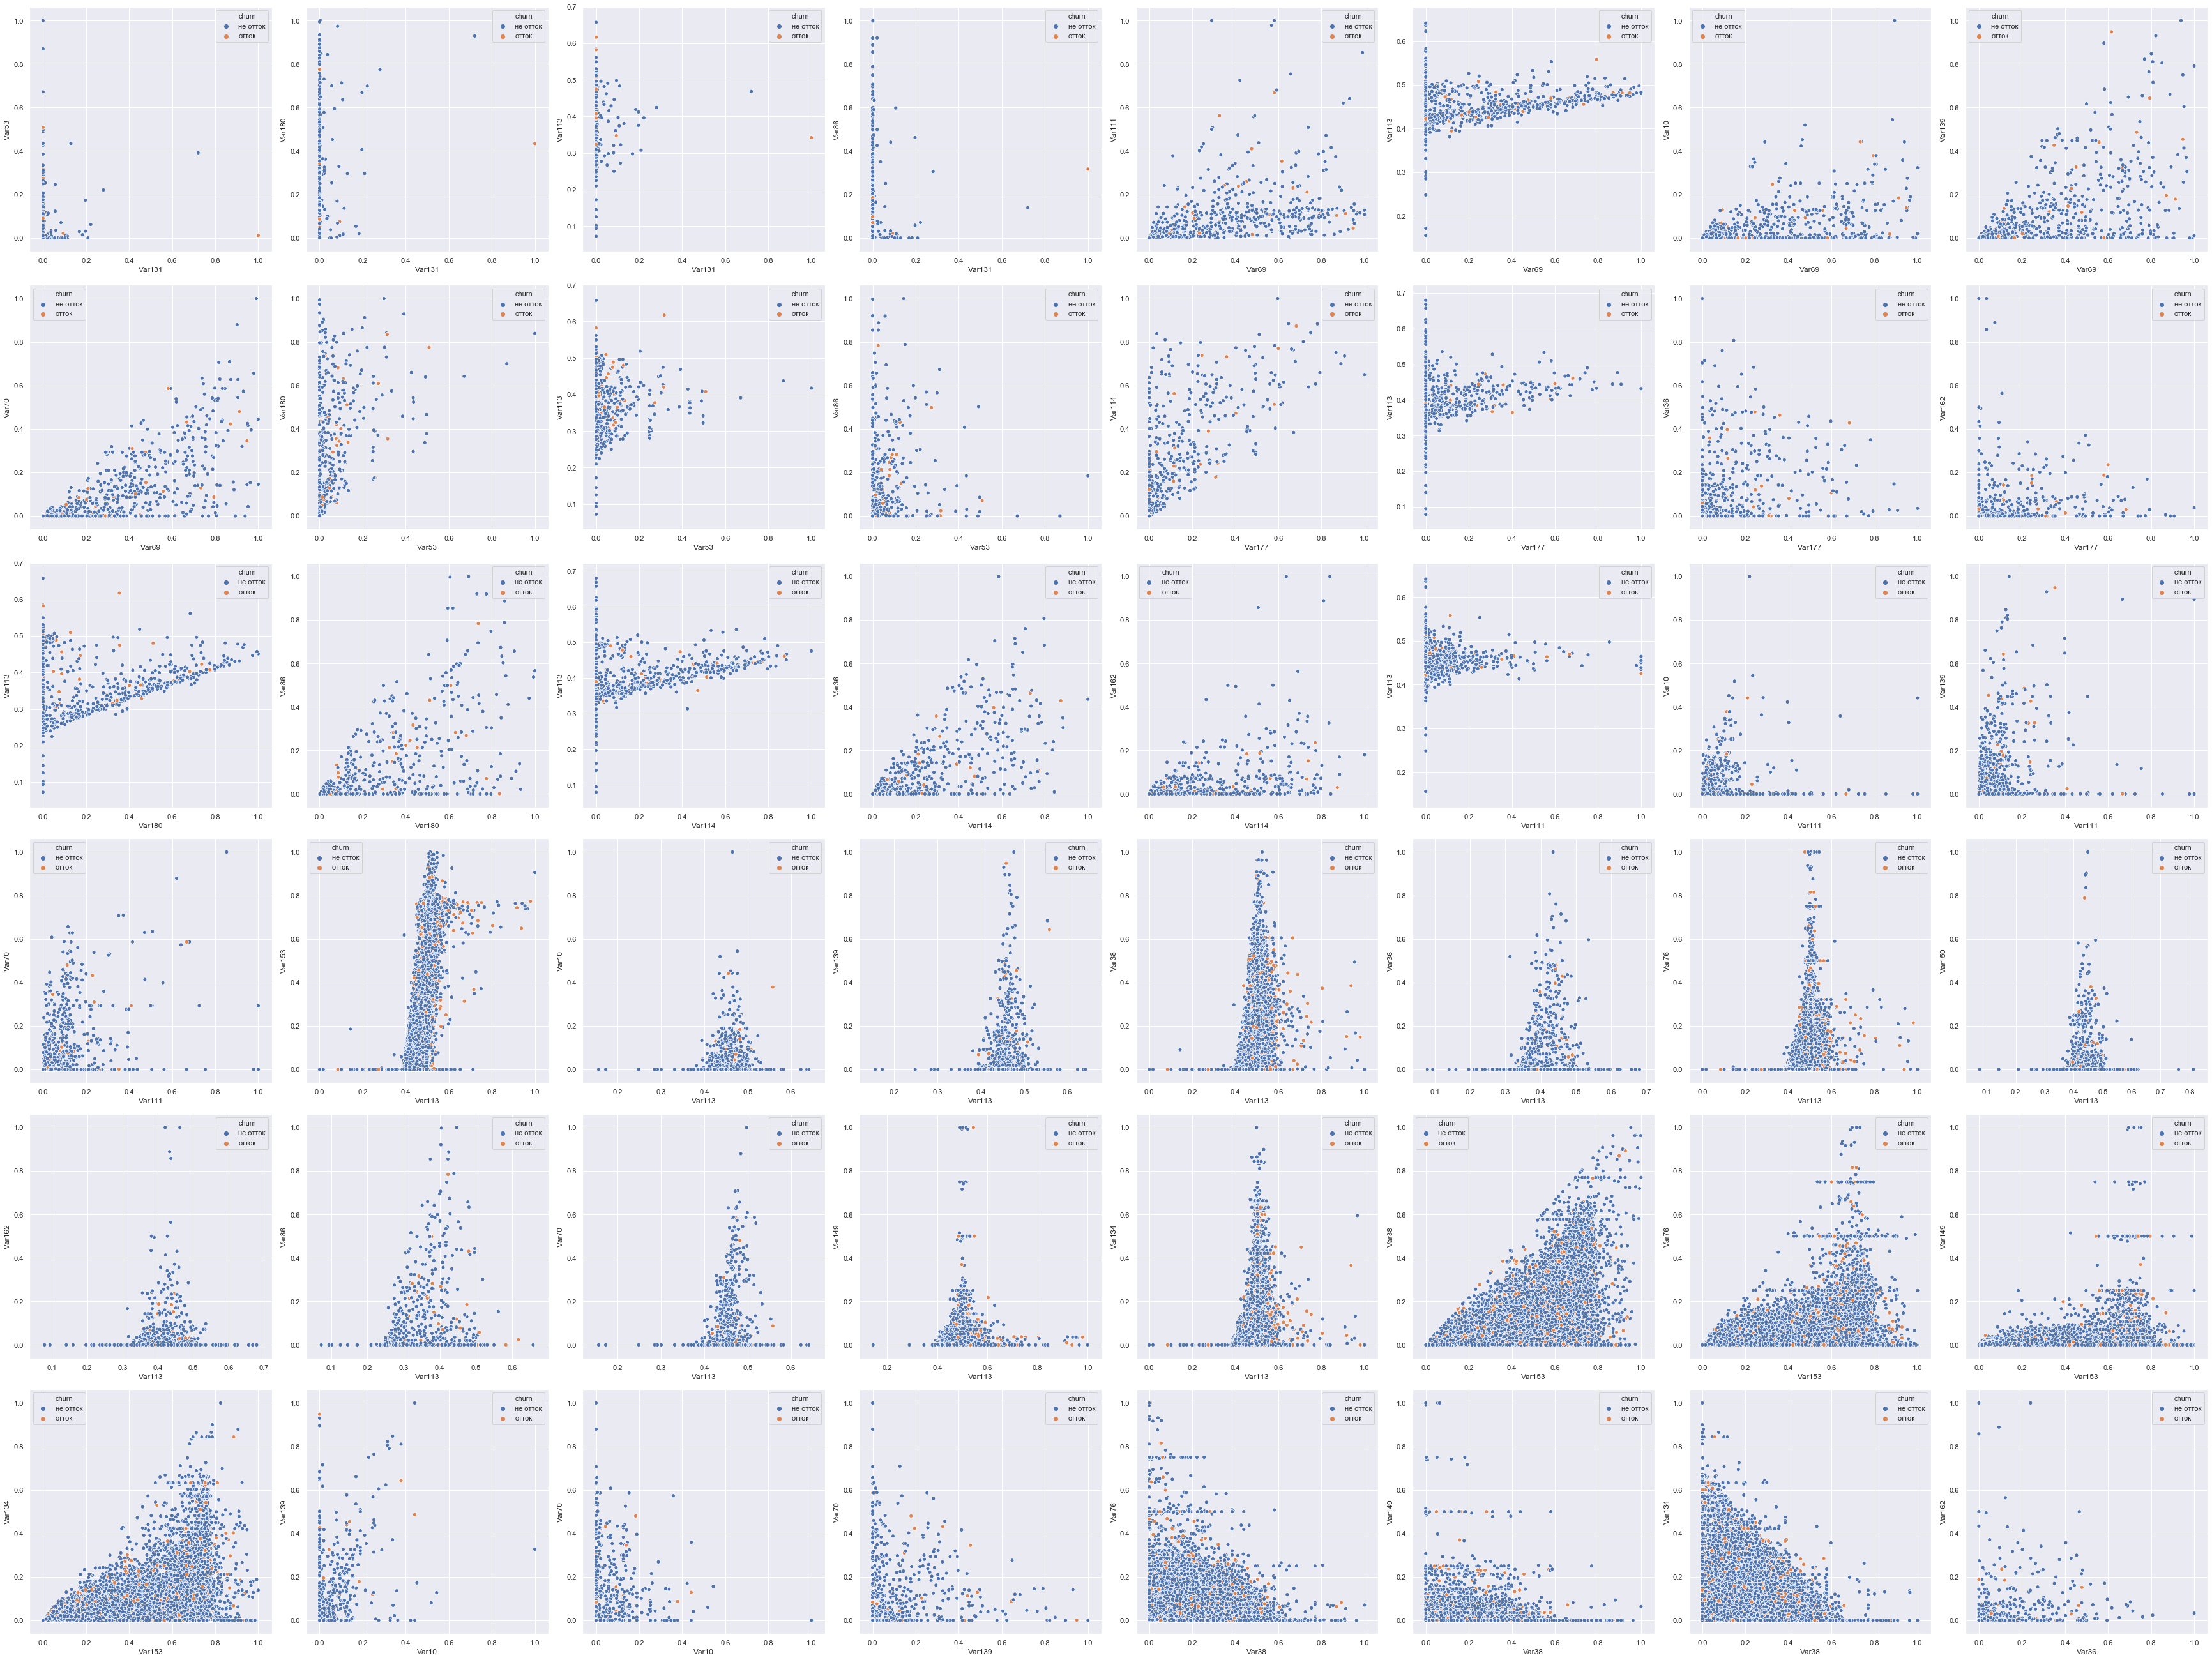

In [84]:
# Вывод попарных сравнений признаков
plot_pairs(norm_top_20)

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

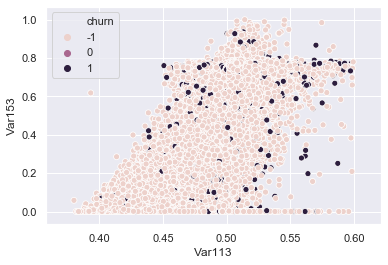

In [90]:
tmp = norm_top_20[['Var153', 'Var113']]
tmp['churn'] = df.churn
tmp = tmp[(tmp.Var113 > 0.38) & (tmp.Var113 < 0.6)]
sns.scatterplot(x='Var113', y='Var153', data=tmp, hue='churn')

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [66]:
num_corrs.sort_values(by='correlation', ascending=True).head()

,correlation
Var154,-141731.558879
Var59,-130636.055601
Var124,-122003.961848
Var33,-98084.971292
Var5,-66949.866756


7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?